In [81]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# nltk.download('vader_lexicon')
import math
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [82]:
data = pd.read_csv('Processed_Data.csv')
data.head()

,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,number_of_words,stopwords_frequency,av_word_per_sen,...,ttr,coherence_score,lexrank_avg_min_diff,lexrank_interquartile,freq_of_noun,freq_of_transition,freq_of_pronoun,noun_to_adj,verb_to_adv,phrase_diversity
0,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,261,0.498084,14.500000,...,0.099639,0.422997,0.245068,0.275570,0.203065,0.065134,0.111111,0.377358,0.317073,0.119650
1,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,533,0.581614,38.071429,...,0.055175,0.506789,0.398650,0.397796,0.200750,0.061914,0.103189,0.373832,0.296875,0.110981
2,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,320,0.515625,16.842105,...,0.073317,0.472376,0.699098,0.433225,0.221875,0.043750,0.090625,0.380282,0.277778,0.105634
3,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,728,0.559066,20.222222,...,0.055877,0.412691,0.629558,0.498259,0.188187,0.043956,0.119505,0.569343,0.184466,0.105024
4,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,234,0.521368,78.000000,...,0.085833,0.551796,0.110281,0.096727,0.230769,0.034188,0.119658,0.481481,0.150000,0.072222


In [83]:
data.columns

Index(['full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology',
       'grammar', 'conventions', 'number_of_words', 'stopwords_frequency',
       'av_word_per_sen', 'punctuations', 'ARI', 'freq_of_verb', 'freq_of_adj',
       'freq_of_adv', 'freq_of_distinct_adj', 'freq_of_distinct_adv',
       'sentence_complexity', 'freq_of_wrong_words', 'sentiment_compound',
       'sentiment_positive', 'sentiment_negative', 'num_of_grammar_errors',
       'corrected_text', 'num_of_short_forms', 'Incorrect_form_ratio',
       'flesch_reading_ease', 'flesch_kincaid_grade',
       'dale_chall_readability_score', 'text_standard', 'mcalpine_eflaw',
       'number_of_diff_words', 'freq_diff_words', 'ttr', 'coherence_score',
       'lexrank_avg_min_diff', 'lexrank_interquartile', 'freq_of_noun',
       'freq_of_transition', 'freq_of_pronoun', 'noun_to_adj', 'verb_to_adv',
       'phrase_diversity'],
      dtype='object')

In [84]:
X = data[['stopwords_frequency','av_word_per_sen', 'punctuations', 'ARI', 'freq_of_verb', 'freq_of_adj',
       'freq_of_adv', 'freq_of_distinct_adj', 'freq_of_distinct_adv',
       'sentence_complexity', 'freq_of_wrong_words', 'sentiment_compound',
       'sentiment_positive', 'sentiment_negative', 'num_of_grammar_errors',
       'num_of_short_forms', 'Incorrect_form_ratio',
       'flesch_reading_ease', 'flesch_kincaid_grade',
       'dale_chall_readability_score', 'text_standard', 'mcalpine_eflaw',
       'number_of_diff_words', 'freq_diff_words', 'ttr', 'coherence_score',
       'lexrank_avg_min_diff', 'lexrank_interquartile', 'freq_of_noun',
       'freq_of_transition', 'freq_of_pronoun', 'noun_to_adj', 'verb_to_adv',
       'phrase_diversity']]

Y = data[['cohesion'
          ,'syntax'
          ,'vocabulary'
          ,'phraseology'
          ,'conventions'
          ,'grammar'
         ]]

In [85]:
def data_split(X, Y, target):
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
    sample_train=Xtrain
    sample_train[target]=Ytrain[target]
    
    sample_test=Xtest
    sample_test[target]=Ytest[target]
    return sample_train, sample_test

In [86]:
sample_train, sample_test=data_split(X,Y,'cohesion')

In [87]:
# Standardize variables
ss = StandardScaler()

features=sample_train.columns.tolist()[:-1]
sample_train.loc[:,features] = ss.fit_transform(sample_train.loc[:,features])
sample_test.loc[:,features] = ss.fit_transform(sample_test.loc[:,features])

In [88]:
# Feature column for the first layer
feature_columns=[]

# Represent all features as floating point value
for feature in X.columns.tolist():
    feature_columns.append(tf.feature_column.numeric_column(feature))
    
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [89]:
# Loss visualization
def plot_the_loss_curve(loss_train, loss_val):
    plt.figure(figsize=(10, 8))
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss vs Validation Loss")

    plt.plot(loss_train, label="Training Loss")
    plt.plot(loss_val, label="Validation Loss")
    plt.legend()
    # plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()  

In [90]:
def train_model(model, dataset, epochs, batch_size, label_name):

  # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=0.2, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']

    return loss_train, loss_val

In [91]:
# Transformation of results
def result(predictions):
    result_list=[]
    for pred in predictions:
        result = pred[0] // 0.5 * 0.5
        if (pred - result) > 0.25:
            result += 0.5
        if result < 1.0:
            result = 1.0
        if result > 5.0:
            result = 5.0
        result_list.append(result)
    return result_list

In [92]:
# Accuracy score
def accuracy(Ytrue, Ypred):
    accurate = 0
    for i in range(len(Ytrue)):
        if Ytrue[i] == Ypred[i]:
            accurate += 1
    return accurate / len(Ytrue)

In [97]:
# Build model
layers = [32,16]

model = tf.keras.models.Sequential()

model.add(feature_layer)

for index, layer in enumerate(layers):
    model.add(tf.keras.layers.Dense(units=layer, 
                                activation='sigmoid', 
                                name=f'Hidden{index}'))

model.add(tf.keras.layers.Dense(units=1, activation='linear'))                             

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['accuracy'])

Epoch 1/50
1/5 [=====>........................] - ETA: 4s - loss: 13.0808 - accuracy: 0.0000e+00WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'stopwords_frequency': <tf.Tensor 'IteratorGetNext:30' shape=(None,) dtype=float32>, 'av_word_per_sen': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=float32>, 'punctuations': <tf.Tensor 'IteratorGetNext:25' shape=(None,) dtype=float32>, 'ARI': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=float32>, 'freq_of_verb': <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtype=float32>, 'freq_of_adj': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=float32>, 'freq_of_adv': <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=float32>, 'freq_of_distinct_adj': <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=float32>, 'freq_of_distinct_adv': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=float32>, 'sentence_complexity': <tf.Tensor 'IteratorGetNext:26' shape=(None,) dtype=float32>, 

5/5 [==============================] - 2s 175ms/step - loss: 6.4122 - accuracy: 0.0020 - val_loss: 1.9097 - val_accuracy: 0.0016
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 1.2468 - accuracy: 0.0028 - val_loss: 0.6587 - val_accuracy: 0.0016
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 0.5131 - accuracy: 0.0028 - val_loss: 0.4029 - val_accuracy: 0.0016
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.3581 - accuracy: 0.0028 - val_loss: 0.3501 - val_accuracy: 0.0016
Epoch 5/50
5/5 [==============================] - 0s 24ms/step - loss: 0.3245 - accuracy: 0.0028 - val_loss: 0.3399 - val_accuracy: 0.0016
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 0.3152 - accuracy: 0.0028 - val_loss: 0.3377 - val_accuracy: 0.0016
Epoch 7/50
5/5 [==============================] - 0s 24ms/step - loss: 0.3104 - accuracy: 0.0028 - val_loss: 0.3357 - val_accuracy: 0.0016
Epoch 8/50
5/5 [=====================

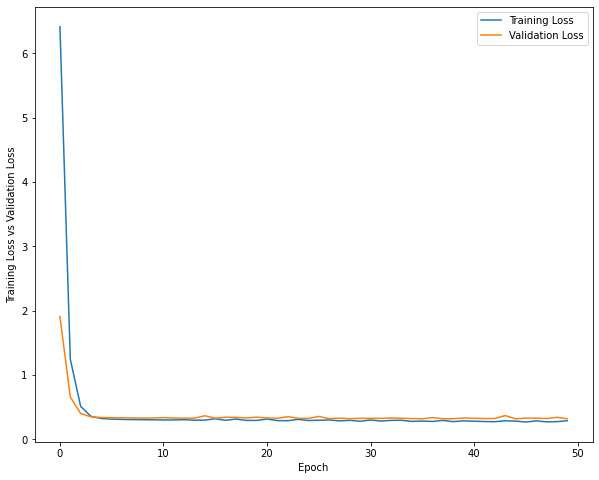

In [98]:
# Train
label_name='cohesion'
number_epochs=50
batch_size=512

loss_train, loss_val = train_model(model, sample_train, number_epochs, batch_size, label_name)
plot_the_loss_curve(loss_train, loss_val)

In [99]:
# Test
test_features = {name:np.array(value) for name, value in sample_test.items()}
test_label = np.array(test_features.pop('cohesion'))

pred = model.predict(test_features)
results=result(pred)

25/25 [==============================] - 0s 2ms/step


In [100]:
accuracy(sample_test['cohesion'].tolist(), results)

0.3243933588761175

In [101]:
pickle.dump(model, open('neural_network.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://4867e84e-6080-4838-8470-d9b110d9acc4/assets


INFO:tensorflow:Assets written to: ram://4867e84e-6080-4838-8470-d9b110d9acc4/assets


### Try oversampling

In [114]:
# !pip install imblearn

In [53]:
from imblearn.over_sampling import SMOTE 

In [54]:
# Transform cohesion into category
target_score=Y['cohesion']
le = LabelEncoder()
target_score=le.fit_transform(target_score)
target_score

array([5, 3, 4, ..., 3, 6, 5], dtype=int64)

In [55]:
smote = SMOTE(random_state=646)

X_os,Y_os = smote.fit_resample(X,target_score)
X_os.shape

(9864, 34)

In [56]:
Y_os = pd.DataFrame(le.inverse_transform(Y_os),columns=['cohesion'])
Y_os

,cohesion
0,3.5
1,2.5
2,3.0
3,4.5
4,2.5
...,...
9859,5.0
9860,5.0
9861,5.0
9862,5.0


In [57]:
train_os,test_os=data_split(X_os,Y_os,'cohesion')

In [58]:
# Build model
layers = [64,32]

model_os = tf.keras.models.Sequential()

model_os.add(feature_layer)

for index, layer in enumerate(layers):
    model_os.add(tf.keras.layers.Dense(units=layer, 
                                activation='sigmoid', 
                                name=f'Hidden{index}'))

model_os.add(tf.keras.layers.Dense(units=1, activation='linear'))                             

model_os.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['accuracy'])

Epoch 1/40
1/5 [=====>........................] - ETA: 5s - loss: 8.5563 - accuracy: 0.0000e+00WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'stopwords_frequency': <tf.Tensor 'IteratorGetNext:30' shape=(None,) dtype=float32>, 'av_word_per_sen': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=float32>, 'punctuations': <tf.Tensor 'IteratorGetNext:25' shape=(None,) dtype=float32>, 'ARI': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=float32>, 'freq_of_verb': <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtype=float32>, 'freq_of_adj': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=float32>, 'freq_of_adv': <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=float32>, 'freq_of_distinct_adj': <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=float32>, 'freq_of_distinct_adv': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=float32>, 'sentence_complexity': <tf.Tensor 'IteratorGetNext:26' shape=(None,) dtype=float32>, '

5/5 [==============================] - 2s 151ms/step - loss: 2.0976 - accuracy: 0.0028 - val_loss: 0.3387 - val_accuracy: 0.0016
Epoch 2/40
5/5 [==============================] - 0s 20ms/step - loss: 0.3172 - accuracy: 0.0028 - val_loss: 0.3310 - val_accuracy: 0.0016
Epoch 3/40
5/5 [==============================] - 0s 20ms/step - loss: 0.3070 - accuracy: 0.0028 - val_loss: 0.3252 - val_accuracy: 0.0016
Epoch 4/40
5/5 [==============================] - 0s 18ms/step - loss: 0.3232 - accuracy: 0.0028 - val_loss: 0.3901 - val_accuracy: 0.0016
Epoch 5/40
5/5 [==============================] - 0s 20ms/step - loss: 0.3556 - accuracy: 0.0028 - val_loss: 0.3879 - val_accuracy: 0.0016
Epoch 6/40
5/5 [==============================] - 0s 21ms/step - loss: 0.3706 - accuracy: 0.0028 - val_loss: 0.4213 - val_accuracy: 0.0016
Epoch 7/40
5/5 [==============================] - 0s 21ms/step - loss: 0.4064 - accuracy: 0.0028 - val_loss: 0.3812 - val_accuracy: 0.0016
Epoch 8/40
5/5 [=====================

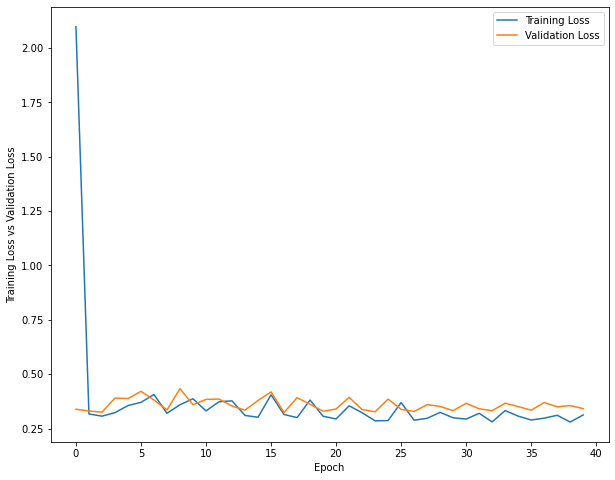

In [59]:
# Train
label_name='cohesion'
number_epochs=40
batch_size=512

loss_train, loss_val = train_model(model_os, sample_train, number_epochs, batch_size, label_name)
plot_the_loss_curve(loss_train, loss_val)

In [60]:
# Test
test_features = {name:np.array(value) for name, value in sample_test.items()}
test_label = np.array(test_features.pop('cohesion'))

pred = model_os.predict(test_features)
results=result(pred)

25/25 [==============================] - 0s 2ms/step


In [61]:
accuracy(sample_test['cohesion'].tolist(), results)

0.33077905491698595

Similar peformance as pre-oversampling, slightly increased

### Vocabulary + Cohesion

In [102]:
# Split data
train_vocab,test_vocab=data_split(X,Y,'vocabulary')

In [103]:
# Standardize
ss = StandardScaler()

features=train_vocab.columns.tolist()[:-1]
sample_train.loc[:,features] = ss.fit_transform(train_vocab.loc[:,features])
sample_test.loc[:,features] = ss.fit_transform(test_vocab.loc[:,features])

Epoch 1/80


1/5 [=====>........................] - ETA: 5s - loss: 6.4012 - accuracy: 0.0000e+00WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'stopwords_frequency': <tf.Tensor 'IteratorGetNext:30' shape=(None,) dtype=float32>, 'av_word_per_sen': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=float32>, 'punctuations': <tf.Tensor 'IteratorGetNext:25' shape=(None,) dtype=float32>, 'ARI': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'freq_of_verb': <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtype=float32>, 'freq_of_adj': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=float32>, 'freq_of_adv': <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=float32>, 'freq_of_distinct_adj': <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=float32>, 'freq_of_distinct_adv': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=float32>, 'sentence_complexity': <tf.Tensor 'IteratorGetNext:26' shape=(None,) dtype=float32>, 'freq_of_wrong

5/5 [==============================] - 2s 162ms/step - loss: 2.4944 - accuracy: 3.9968e-04 - val_loss: 0.5216 - val_accuracy: 0.0000e+00
Epoch 2/80
5/5 [==============================] - 0s 28ms/step - loss: 0.4138 - accuracy: 3.9968e-04 - val_loss: 0.3376 - val_accuracy: 0.0000e+00
Epoch 3/80
5/5 [==============================] - 0s 28ms/step - loss: 0.3396 - accuracy: 3.9968e-04 - val_loss: 0.3236 - val_accuracy: 0.0000e+00
Epoch 4/80
5/5 [==============================] - 0s 21ms/step - loss: 0.3324 - accuracy: 3.9968e-04 - val_loss: 0.3181 - val_accuracy: 0.0000e+00
Epoch 5/80
5/5 [==============================] - 0s 21ms/step - loss: 0.3258 - accuracy: 3.9968e-04 - val_loss: 0.3098 - val_accuracy: 0.0000e+00
Epoch 6/80
5/5 [==============================] - 0s 22ms/step - loss: 0.3162 - accuracy: 3.9968e-04 - val_loss: 0.2965 - val_accuracy: 0.0000e+00
Epoch 7/80
5/5 [==============================] - 0s 21ms/step - loss: 0.3047 - accuracy: 3.9968e-04 - val_loss: 0.2818 - val_ac

5/5 [==============================] - 0s 20ms/step - loss: 0.2128 - accuracy: 3.9968e-04 - val_loss: 0.2105 - val_accuracy: 0.0000e+00
Epoch 57/80
5/5 [==============================] - 0s 20ms/step - loss: 0.2148 - accuracy: 3.9968e-04 - val_loss: 0.2573 - val_accuracy: 0.0000e+00
Epoch 58/80
5/5 [==============================] - 0s 20ms/step - loss: 0.2467 - accuracy: 3.9968e-04 - val_loss: 0.2089 - val_accuracy: 0.0000e+00
Epoch 59/80
5/5 [==============================] - 0s 21ms/step - loss: 0.2182 - accuracy: 3.9968e-04 - val_loss: 0.2098 - val_accuracy: 0.0000e+00
Epoch 60/80
5/5 [==============================] - 0s 20ms/step - loss: 0.2352 - accuracy: 3.9968e-04 - val_loss: 0.2407 - val_accuracy: 0.0000e+00
Epoch 61/80
5/5 [==============================] - 0s 19ms/step - loss: 0.2210 - accuracy: 3.9968e-04 - val_loss: 0.2215 - val_accuracy: 0.0000e+00
Epoch 62/80
5/5 [==============================] - 0s 23ms/step - loss: 0.2127 - accuracy: 3.9968e-04 - val_loss: 0.2174 - v

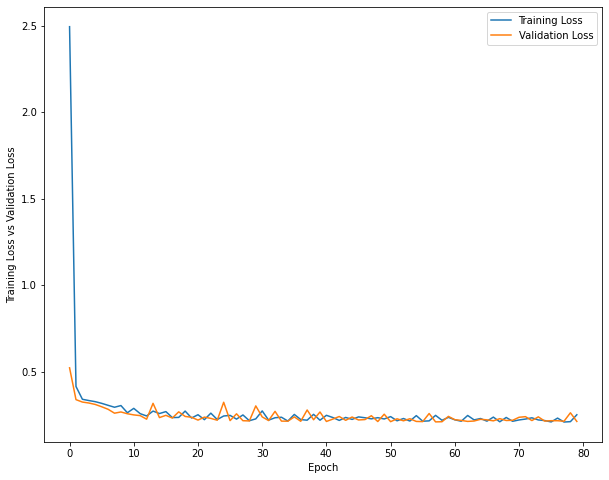

In [104]:
# Define model
layers = [32,16]

model_vocab = tf.keras.models.Sequential()

model_vocab.add(feature_layer)

for index, layer in enumerate(layers):
    model_vocab.add(tf.keras.layers.Dense(units=layer, 
                                activation='sigmoid', 
                                name=f'Hidden{index}'))

model_vocab.add(tf.keras.layers.Dense(units=1, activation='linear'))                             

model_vocab.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['accuracy'])

# Train
label_name='vocabulary'
number_epochs=80
batch_size=512

loss_train, loss_val = train_model(model_vocab, train_vocab, number_epochs, batch_size, label_name)
plot_the_loss_curve(loss_train, loss_val)

In [105]:
test_features = {name:np.array(value) for name, value in test_vocab.items()}
test_label = np.array(test_features.pop('vocabulary'))

pred = model_vocab.predict(test_features)
results=result(pred)

25/25 [==============================] - 0s 2ms/step


In [106]:
accuracy(test_vocab['vocabulary'].tolist(), results)

0.421455938697318

In [107]:
# Use vocabulary prediction as a feature for cohesion
train_cohesion, test_cohesion=data_split(X,Y,'cohesion')

In [108]:
train_cohesion_features={name:np.array(value) for name, value in train_cohesion.items()}
cohesion=train_cohesion_features.pop('cohesion')
train_cohesion['vocab_pred']=result(model_vocab.predict(train_cohesion_features))
train_cohesion['cohesion']=cohesion


test_cohesion_features={name:np.array(value) for name, value in test_cohesion.items()}
cohesion=test_cohesion_features.pop('cohesion')
test_cohesion['vocab_pred']=result(model_vocab.predict(test_cohesion_features))
test_cohesion['cohesion']=cohesion

25/25 [==============================] - 0s 3ms/step


In [109]:
new_feature_columns = []
new_features=X.columns.tolist()
new_features.append('vocab_pred')
for feature in new_features:
    new_feature_columns.append(tf.feature_column.numeric_column(feature))

In [110]:
new_feature_layer = tf.keras.layers.DenseFeatures(new_feature_columns)

In [111]:
train_cohesion.loc[:,new_features] = ss.fit_transform(train_cohesion.loc[:,new_features])
test_cohesion.loc[:,new_features] = ss.fit_transform(test_cohesion.loc[:,new_features])
train_cohesion.head()

,stopwords_frequency,av_word_per_sen,punctuations,ARI,freq_of_verb,freq_of_adj,freq_of_adv,freq_of_distinct_adj,freq_of_distinct_adv,sentence_complexity,...,lexrank_avg_min_diff,lexrank_interquartile,freq_of_noun,freq_of_transition,freq_of_pronoun,noun_to_adj,verb_to_adv,phrase_diversity,cohesion,vocab_pred
247,1.247731,-0.030736,-0.525132,-0.114498,1.817767,-2.018700,-0.186919,-1.303064,0.567306,1.600694,...,-0.730996,-0.345988,-0.243638,3.493509,1.145244,-1.611829,-0.763030,-1.178400,4.0,-0.529695
1360,0.085112,0.509118,-0.165777,0.557873,-0.310885,-0.936700,0.572096,-0.930667,0.138874,0.684053,...,1.054039,1.755357,0.718219,-1.067948,-1.912111,-1.115339,0.481589,-0.306024,3.5,0.823970
3318,1.416117,0.099471,-0.518102,0.034918,-0.453924,0.026785,0.647894,-0.291714,0.217842,-0.374319,...,0.755371,-0.695553,-1.182825,0.238351,0.207150,0.787872,0.637166,1.085141,2.0,-0.529695
2337,0.035849,-0.255069,-0.638057,-0.263914,1.323250,-0.196411,1.313324,-0.057260,1.350135,0.012177,...,-0.624983,-0.339434,-1.290919,-0.986491,0.573552,0.662670,0.162387,0.500749,3.0,-0.529695
3631,-1.130107,-0.262818,1.658664,-0.189206,-1.562337,1.784218,-0.911503,1.267133,-0.450313,-0.217417,...,-0.414048,0.015241,1.125797,0.902812,-2.272878,0.529303,-0.062932,0.197716,2.5,-0.529695


Epoch 1/100


1/5 [=====>........................] - ETA: 4s - loss: 11.1916 - accuracy: 0.0020WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'stopwords_frequency': <tf.Tensor 'IteratorGetNext:30' shape=(None,) dtype=float32>, 'av_word_per_sen': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=float32>, 'punctuations': <tf.Tensor 'IteratorGetNext:25' shape=(None,) dtype=float32>, 'ARI': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=float32>, 'freq_of_verb': <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtype=float32>, 'freq_of_adj': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=float32>, 'freq_of_adv': <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=float32>, 'freq_of_distinct_adj': <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=float32>, 'freq_of_distinct_adv': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=float32>, 'sentence_complexity': <tf.Tensor 'IteratorGetNext:26' shape=(None,) dtype=float32>, 'freq_of_wrong_

5/5 [==============================] - 2s 168ms/step - loss: 8.0206 - accuracy: 3.9968e-04 - val_loss: 4.5671 - val_accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 21ms/step - loss: 3.3027 - accuracy: 7.9936e-04 - val_loss: 1.5205 - val_accuracy: 0.0016
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 1.1644 - accuracy: 0.0024 - val_loss: 0.7967 - val_accuracy: 0.0016
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 0.6831 - accuracy: 0.0024 - val_loss: 0.7948 - val_accuracy: 0.0016
Epoch 5/100
5/5 [==============================] - 0s 21ms/step - loss: 0.5935 - accuracy: 0.0028 - val_loss: 0.4511 - val_accuracy: 0.0016
Epoch 6/100
5/5 [==============================] - 0s 22ms/step - loss: 0.4513 - accuracy: 0.0028 - val_loss: 0.4945 - val_accuracy: 0.0016
Epoch 7/100
5/5 [==============================] - 0s 23ms/step - loss: 0.4541 - accuracy: 0.0028 - val_loss: 0.4533 - val_accuracy: 0.0016
Epoch 8/100
5/5 [==

5/5 [==============================] - 0s 21ms/step - loss: 0.2739 - accuracy: 0.0024 - val_loss: 0.3288 - val_accuracy: 0.0016
Epoch 60/100
5/5 [==============================] - 0s 23ms/step - loss: 0.2819 - accuracy: 0.0028 - val_loss: 0.3220 - val_accuracy: 0.0016
Epoch 61/100
5/5 [==============================] - 0s 24ms/step - loss: 0.2770 - accuracy: 0.0028 - val_loss: 0.3241 - val_accuracy: 0.0016
Epoch 62/100
5/5 [==============================] - 0s 22ms/step - loss: 0.2731 - accuracy: 0.0028 - val_loss: 0.3306 - val_accuracy: 0.0016
Epoch 63/100
5/5 [==============================] - 0s 22ms/step - loss: 0.2769 - accuracy: 0.0028 - val_loss: 0.3402 - val_accuracy: 0.0016
Epoch 64/100
5/5 [==============================] - 0s 21ms/step - loss: 0.2702 - accuracy: 0.0028 - val_loss: 0.3549 - val_accuracy: 0.0016
Epoch 65/100
5/5 [==============================] - 0s 21ms/step - loss: 0.2728 - accuracy: 0.0028 - val_loss: 0.3281 - val_accuracy: 0.0016
Epoch 66/100
5/5 [========

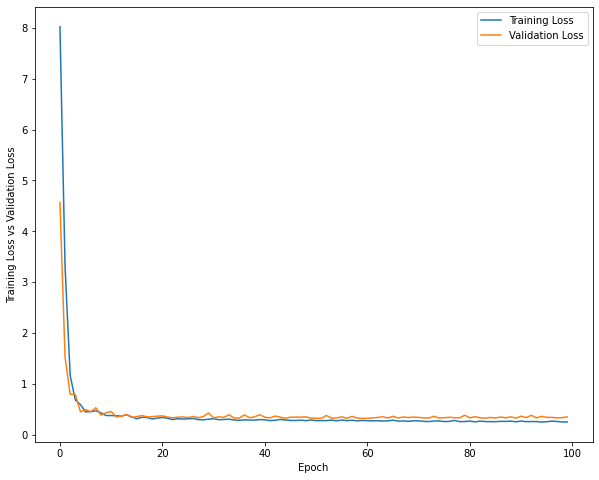

In [112]:
layers = [32,16]

model_new = tf.keras.models.Sequential()

model_new.add(new_feature_layer)
model_new.add(tf.keras.layers.Dropout(0.2))     
for index, layer in enumerate(layers):
    model_new.add(tf.keras.layers.Dense(units=layer, 
                                activation='tanh', 
                                name=f'Hidden{index}'))

model_new.add(tf.keras.layers.Dense(units=1, activation='linear'))                             

model_new.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['accuracy'])

label_name='cohesion'
number_epochs=100
batch_size=512

loss_train, loss_val = train_model(model_new, train_cohesion, number_epochs, batch_size, label_name)
plot_the_loss_curve(loss_train, loss_val)

In [113]:
test_features = {name:np.array(value) for name, value in test_cohesion.items()}
test_label = np.array(test_features.pop('cohesion'))

pred = model_new.predict(test_features)
results=result(pred)
results

25/25 [==============================] - 0s 2ms/step


[2.0,
 2.5,
 3.5,
 3.0,
 2.5,
 3.5,
 2.5,
 3.0,
 2.5,
 3.0,
 3.0,
 3.0,
 3.5,
 3.5,
 3.5,
 3.5,
 4.0,
 4.0,
 4.0,
 3.5,
 3.5,
 4.0,
 3.0,
 3.0,
 3.5,
 2.5,
 3.0,
 3.0,
 2.5,
 3.0,
 3.5,
 2.5,
 2.5,
 3.0,
 3.5,
 3.0,
 3.0,
 3.5,
 3.5,
 3.0,
 2.5,
 3.5,
 2.5,
 2.5,
 4.0,
 3.5,
 3.5,
 2.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.0,
 2.5,
 3.0,
 3.0,
 4.0,
 2.5,
 3.0,
 2.5,
 3.0,
 3.5,
 3.5,
 3.5,
 3.0,
 3.5,
 2.5,
 3.5,
 3.5,
 4.0,
 2.5,
 3.5,
 3.5,
 3.5,
 3.5,
 3.0,
 4.0,
 3.5,
 3.0,
 3.0,
 3.0,
 2.5,
 3.5,
 3.0,
 4.0,
 3.0,
 2.5,
 3.0,
 3.5,
 3.0,
 4.0,
 3.5,
 4.0,
 3.0,
 3.5,
 4.0,
 3.0,
 3.0,
 3.0,
 3.5,
 2.5,
 3.5,
 4.0,
 3.0,
 2.5,
 2.5,
 3.5,
 3.0,
 3.0,
 3.0,
 3.5,
 4.0,
 3.5,
 3.5,
 3.0,
 3.0,
 4.0,
 3.0,
 2.5,
 4.0,
 3.0,
 3.5,
 3.5,
 3.0,
 2.5,
 3.0,
 3.5,
 3.5,
 3.5,
 2.5,
 3.0,
 3.5,
 3.0,
 3.0,
 2.5,
 3.0,
 3.0,
 3.0,
 4.0,
 4.5,
 3.5,
 3.0,
 3.5,
 3.0,
 3.0,
 3.0,
 3.5,
 3.0,
 3.5,
 2.5,
 3.5,
 2.5,
 3.5,
 3.5,
 3.0,
 3.0,
 3.5,
 4.0,
 4.0,
 3.5,
 2.5,
 3.0,
 3.0,
 3.5,
 3.0,
 3.5,
 3.5

In [114]:
accuracy(sample_test['cohesion'].tolist(), results)

0.34099616858237547

In [115]:
pickle.dump(model_new, open('neural_network_vocab.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://fc834760-253d-4481-aad9-2bff220c30c7/assets


INFO:tensorflow:Assets written to: ram://fc834760-253d-4481-aad9-2bff220c30c7/assets


Slightly higher than previous model without vocab_pred

In [ ]:
# Accuracy measurement score
pickle.dump(model, open('modelname.sav', 'wb'))

In [ ]:
ls_model = pickle.load(open("ls_model.sav", 'rb'))